# LAB 1: Kernel Ridge Regression
Authors: 

    Mathurin Massias (mathurin.massias@gmail.com)
    
    Giacomo Meanti  (giacomo.meanti@gmail.com)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn import datasets

from lab1_utils import create_random_data, data_split

## Warmup

### Data Generation

In [23]:
X, y = create_random_data(1000, 1, seed=932)

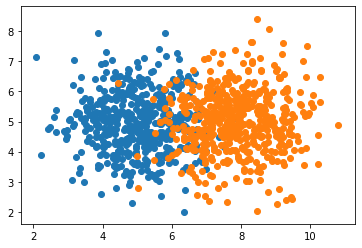

In [24]:
fig, ax = plt.subplots()
ax.scatter(X[y == -1][:,0], X[y == -1][:,1])
ax.scatter(X[y == 1][:,0], X[y == 1][:,1])

### Splitting the data into train and test

In [27]:
X_train, X_test, y_train, y_test = data_split(X, y, n_train=800)
print("%d training samples, %d test samples" % (X_train.shape[0], X_test.shape[0]))

800 training samples, 200 test samples


### Training a linear ridge-regression model

In [28]:
def plot_separation(X, Y, model):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z[Z < 0] = -1
    Z[Z >= 0] = 1

    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    plt.scatter(X[Y == -1][:,0], X[Y == -1][:,1])
    plt.scatter(X[Y == 1][:,0], X[Y == 1][:,1])

def binary_classif_error(true, predictions):
    predictions[predictions < 0] = -1
    predictions[predictions >= 0] = 1
    return np.mean(predictions != true)

In [48]:
regularization = 0.001

model = KernelRidge(regularization, kernel="linear")
model.fit(X_train, y_train)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

In [49]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Training error: %.2f%%" % (binary_classif_error(y_train, train_preds) * 100))
print("Test error: %.2f%%" % (binary_classif_error(y_test, test_preds) * 100))

Training error: 19.88%
Test error: 19.50%


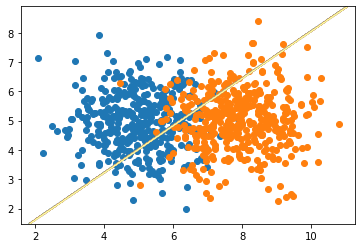

In [50]:
plot_separation(X_train, y_train, model)

### Exploring the effect of different parameters

In [46]:
# 1. Change the regularization parameter
reg_values = [0.0001, 1.0, 10, 100, 500, 1000, 5000]
test_errors = []
for reg in reg_values:
    model = KernelRidge(reg, kernel="linear")
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_errors.append(binary_classif_error(y_test, test_preds))

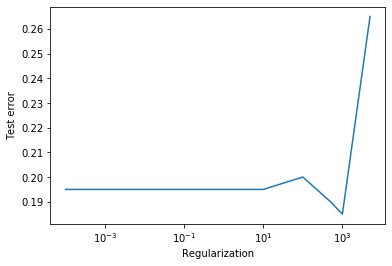

In [47]:
fig, ax = plt.subplots()
ax.plot(reg_values, test_errors)
ax.set_xlabel("Regularization")
ax.set_ylabel("Test error")
ax.set_xscale('log')

In [62]:
# 2. Change in number of data-points
num_points = [1000, 2000, 3000, 4000, 5000]
np_test_errors = []
model = KernelRidge(1, kernel="linear")
for points in num_points:
    X, y = create_random_data(points, 0.5, seed=932)
    X_train, X_test, y_train, y_test = data_split(X, y, n_train=points - 200)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    np_test_errors.append(binary_classif_error(y_test, test_preds))

Text(0, 0.5, 'Test error')

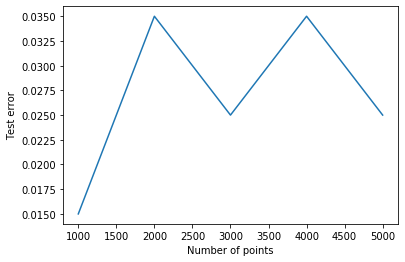

In [63]:
fig, ax = plt.subplots()
ax.plot(num_points, np_test_errors)
ax.set_xlabel("Number of points")
ax.set_ylabel("Test error")

In [65]:
# 3. Amount of noise in the data
# 2. Change in number of data-points
data_noise = [0.3, 0.5, 1.0, 2.0]
noise_test_errors = []
model = KernelRidge(1, kernel="linear")
for noise in data_noise:
    X, y = create_random_data(1000, noise, seed=932)
    X_train, X_test, y_train, y_test = data_split(X, y, n_train=800)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    noise_test_errors.append(binary_classif_error(y_test, test_preds))

Text(0, 0.5, 'Test error')

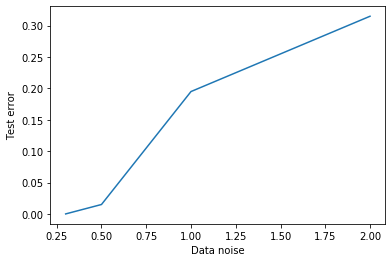

In [66]:
fig, ax = plt.subplots()
ax.plot(data_noise, noise_test_errors)
ax.set_xlabel("Data noise")
ax.set_ylabel("Test error")

### Cross-Validation

## Part 2: Kernel ridge regression